In [277]:
# LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import r2_score,roc_auc_score,classification_report,mean_squared_error,accuracy_score,confusion_matrix,precision_score,recall_score
from sklearn.svm import SVC
import tensorflow as tf

In [278]:
# READING
master=pd.read_csv('D:/Sentiment Analysis/Jobs/fake_job_postings.csv')
master.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [279]:
#CHECK DTYPES
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [280]:
#CHECK NA
master.isnull().sum()/len(master)*100

job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.072707
benefits               40.324385
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64

In [281]:
#copy
masterd=master.copy()

# MISSING VALUE TREATMENT#

In [282]:

columns=['job_id', 'telecommuting', 'has_company_logo', 'has_questions', 'salary_range', 'employment_type']
for col in columns:
    del master[col]

master.fillna(' ', inplace=True)

def split(location):
    l = location.split(',')
    return l[0]

master['country'] = master.location.apply(split)

master.head()

,title,location,department,company_profile,description,requirements,benefits,required_experience,required_education,industry,function,fraudulent,country
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,Internship,,,Marketing,0,US
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Not Applicable,,Marketing and Advertising,Customer Service,0,NZ
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,,,,,0,US
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US
4,Bill Review Manager,"US, FL, Fort Worth",,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US


# TARGET VARIABLE # 

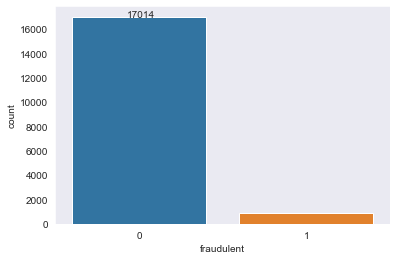

In [283]:
#FAKE JOBS ARE HIGH AS COMPARED TO TRUE ONES#

plt.figure(figsize=(6, 4))
ax=sns.set_style("dark")
ax=sns.countplot(master.fraudulent)
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.33, p.get_height()))
    
    plt.show()

# Category vs Target#

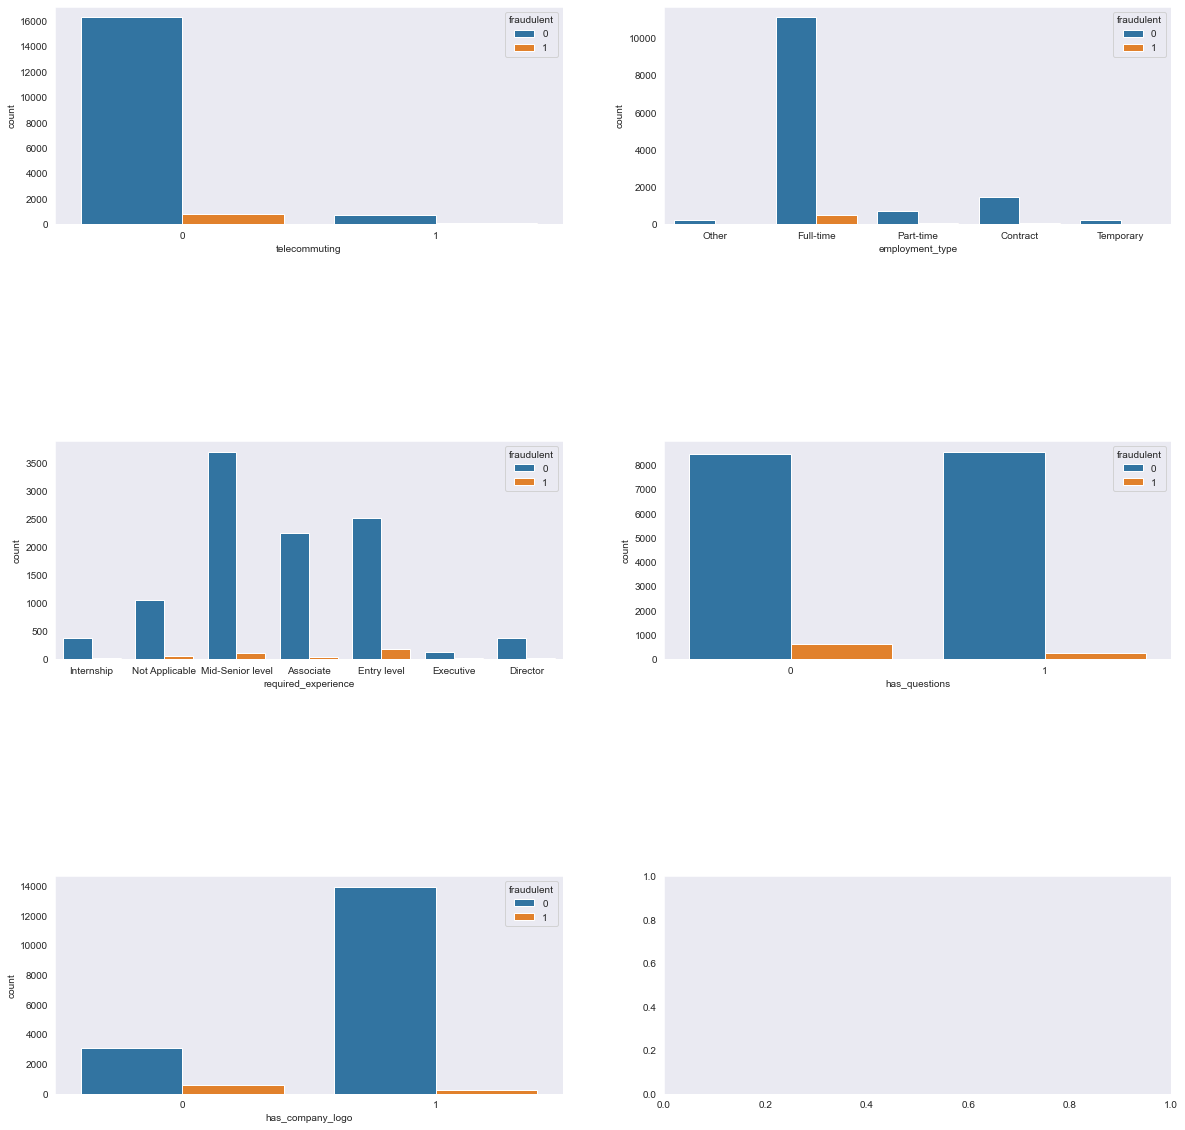

In [284]:

ts={"telecommuting", "has_company_logo", "has_questions", "employment_type", "required_experience"}
fig,axes = plt.subplots(3,2,figsize=(20,20))
for idx,cat_col in enumerate(ts):
    row,col = idx//2,idx%2
    sns.countplot(x=cat_col,data=masterd,hue='fraudulent',ax=axes[row,col])
plt.subplots_adjust(hspace=1)

# MERGING#

In [285]:
master['text']=master['title']+' '+master['location']+' '+master['company_profile']+' '+master['description']+' '+master['requirements']+' '+master['benefits']
del master['title']
del master['location']
del master['department']
del master['company_profile']
del master['description']
del master['requirements']
del master['benefits']
del master['required_experience']
del master['required_education']
del master['industry']
del master['function']
del master['country']

# CLEANING TEXT#

In [286]:

%time
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
master['text'] = master['text'].apply(lambda x: clean_text(x))
master.head(3)

Wall time: 0 ns


,fraudulent,text
0,0,marketing intern us ny new york were and weve...
1,0,customer service cloud video production nz a...
2,0,commissioning machinery assistant cma us ia we...


# TOKENIZING#

In [287]:
%time
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

# appling tokenizer5
master['text'] = master['text'].apply(lambda x: tokenizer.tokenize(x))
master.head(3)

Wall time: 0 ns


,fraudulent,text
0,0,"[marketing, intern, us, ny, new, york, were, a..."
1,0,"[customer, service, cloud, video, production, ..."
2,0,"[commissioning, machinery, assistant, cma, us,..."


# STOPWORDS REMOVAL#

In [288]:

%time
stop_words = stopwords.words('english')

wc =WordNetLemmatizer()
def remove_stopwords(text):
    """
    Removing stopwords belonging to english language
    
    """
    words = [wc.lemmatize(w) for w in text if w not in stop_words]
    return words


master['text'] = master['text'].apply(lambda x : remove_stopwords(x))
master['text'].head(3)

Wall time: 0 ns


0    [marketing, intern, u, ny, new, york, weve, cr...
1    [customer, service, cloud, video, production, ...
2    [commissioning, machinery, assistant, cma, u, ...
Name: text, dtype: object

In [289]:
%%time
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

master['text'] = master['text'].apply(lambda x : combine_text(x))
master['text'].head(3)

Wall time: 435 ms


0    marketing intern u ny new york weve created gr...
1    customer service cloud video production nz auc...
2    commissioning machinery assistant cma u ia wev...
Name: text, dtype: object

# TRUE JOBS#

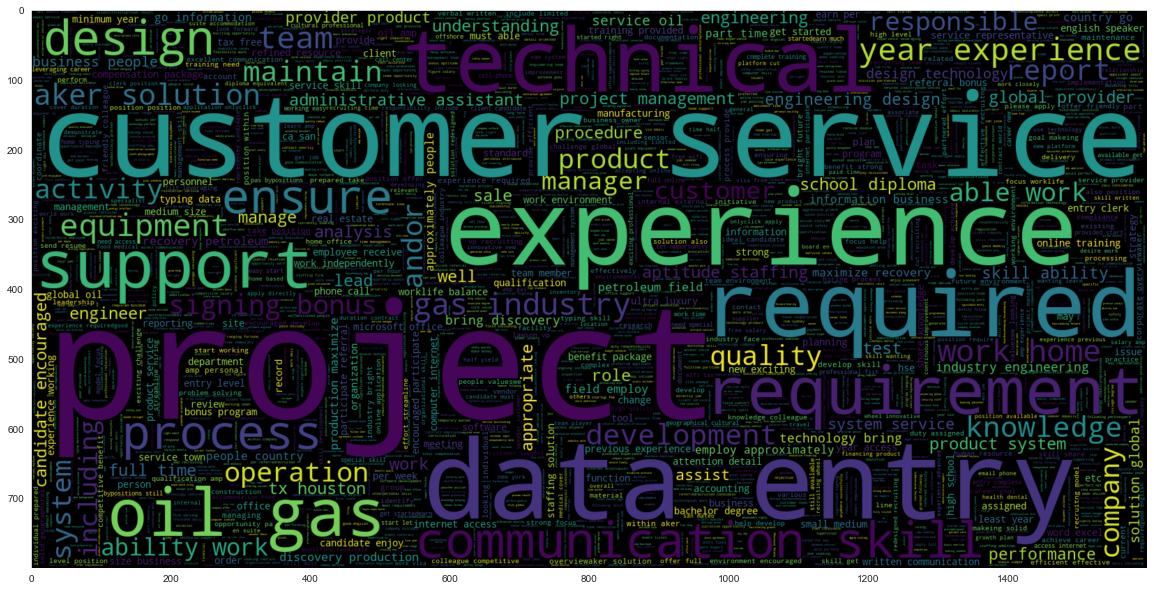

In [290]:
#True
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(master[master.fraudulent == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

# FALSE JOBS#

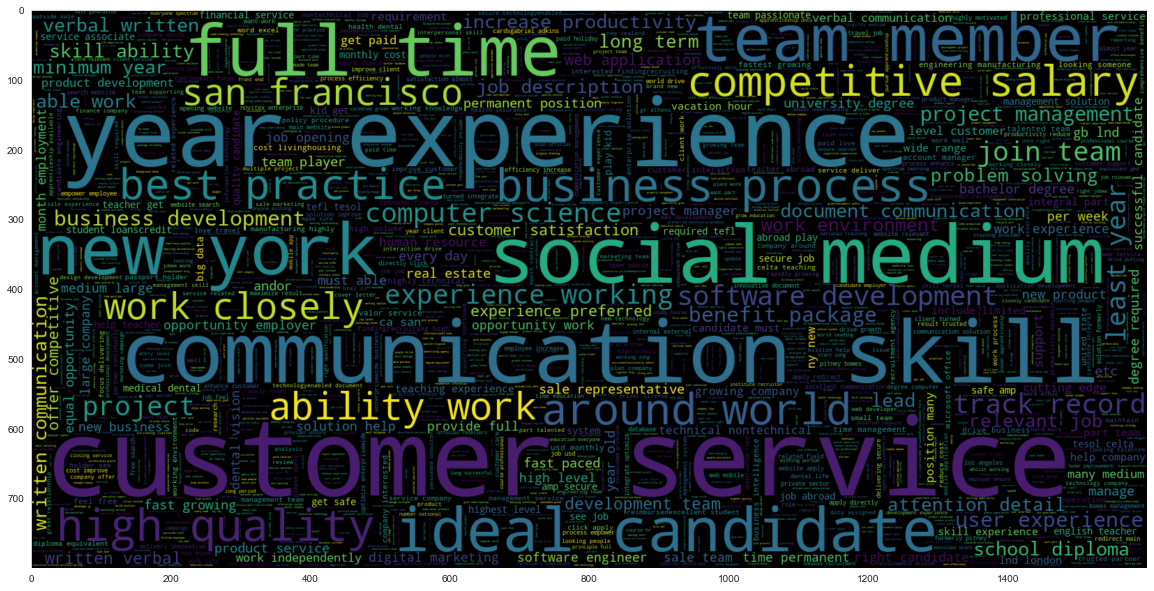

In [291]:
#False
plt.figure(figsize = (20,20)) # Text that is not Fake
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(master[master.fraudulent == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

# COUNT VECTORIZATION#

In [292]:
cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
X = cv.fit_transform(master['text']).toarray()
y=master.fraudulent


# TRAIN & TEST SPLIT #

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
cv.get_feature_names()[:20]

['ab',
 'abc',
 'abc supply',
 'ability',
 'ability adapt',
 'ability build',
 'ability communicate',
 'ability effectively',
 'ability manage',
 'ability multitask',
 'ability prioritize',
 'ability work',
 'ability work independently',
 'ability work well',
 'able',
 'able perform',
 'able work',
 'able work independently',
 'abroad',
 'abroad conversational']

# LOGISTIC REGRESSION#

In [294]:


clf = LogisticRegression()

# fitting our model.
clf.fit(X_train,y_train)

# Predicting with a test dataset
predicted = clf.predict(X_test)

# Model Accuracy
print("Logistic Regression Accuracy:", accuracy_score(y_test, predicted))
print(classification_report(y_test,predicted))

C:\Users\98686\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Logistic Regression Accuracy: 0.983053719708524
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5646
           1       0.82      0.78      0.80       255

    accuracy                           0.98      5901
   macro avg       0.91      0.88      0.89      5901
weighted avg       0.98      0.98      0.98      5901



In [296]:
# These are the class weights for each class
class_1 =( len(y) - len(y[y==0]))/len(y)
class_2 =( len(y) - len(y[y==1]))/len(y)
print(class_1,class_2)

0.04843400447427293 0.9515659955257271


# LIGHT GBM#

In [301]:
#LIGHT GBM#

weight = {0: '0.48', 1: '0.95'}
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold

err = []
y_pred_tot_lgm = []

from sklearn.model_selection import StratifiedKFold

fold = StratifiedKFold(n_splits=15, shuffle=True, random_state=42)
i = 1
for train_index, test_index in fold.split(X, y):
    x_train, x_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
    m = LGBMClassifier(boosting_type='gbdt',
                       max_depth=5,
                       learning_rate=0.05,
                       n_estimators=5000,
                       class_weight = weight,
                       min_child_weight = 0.02,
                       colsample_bytree=0.6, 
                       random_state=7,
                       objective='binary')
    m.fit(x_train, y_train,
          eval_set=[(x_train,y_train),(x_val, y_val)],
          early_stopping_rounds=200,
          verbose=200)
    pred_y = m.predict(x_val)
    print(i, " err_lgm: ", accuracy_score(y_val, pred_y))
    err.append(accuracy_score(y_val, pred_y))
    pred_test = m.predict(X_test)
    i = i + 1
    y_pred_tot_lgm.append(pred_test)

Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.0620132	valid_1's binary_logloss: 0.0650037
[400]	training's binary_logloss: 0.0338019	valid_1's binary_logloss: 0.0500129
[600]	training's binary_logloss: 0.0206628	valid_1's binary_logloss: 0.0450389
[800]	training's binary_logloss: 0.0128252	valid_1's binary_logloss: 0.0438687
[1000]	training's binary_logloss: 0.00820663	valid_1's binary_logloss: 0.0432854
[1200]	training's binary_logloss: 0.00526269	valid_1's binary_logloss: 0.0426015
Early stopping, best iteration is:
[1173]	training's binary_logloss: 0.00562575	valid_1's binary_logloss: 0.0424804
1  err_lgm:  0.9865771812080537
Training until validation scores don't improve for 200 rounds
[200]	training's binary_logloss: 0.0629751	valid_1's binary_logloss: 0.057586
[400]	training's binary_logloss: 0.0351803	valid_1's binary_logloss: 0.0439781
[600]	training's binary_logloss: 0.0215148	valid_1's binary_logloss: 0.0383207
[800]	training